# Blob points classification with a kNN model

In [89]:
%pylab inline
import numpy
import scipy
from sklearn.datasets import make_blobs
numpy.random.seed(1234)

Populating the interactive namespace from numpy and matplotlib


In [67]:
def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

# students, try to shift mean coordinates and check how it changes the performance
n_dim = 2
x_tra, y_tra = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_tes, y_tes = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.9)

In [68]:
# mapping blobs on diagonals belong to the same class

y_tra = label_map(y_tra, [0, 1], 0)
y_tra = label_map(y_tra, [2, 3], 1)
y_tes = label_map(y_tes, [0, 1], 0)
y_tes = label_map(y_tes, [2, 3], 1)

In [69]:
def knn_classify(x_, x, y, metric='euclidean', k=1):
    if len(x_.shape) < 2:
        x_ = x_.reshape([1,-1])
    dists = scipy.spatial.distance.cdist(x_, x, metric)
    sidx = numpy.argpartition(dists, k, axis=1)[:,:k]
    y_ = numpy.zeros(len(x_))
    for ii, xx_ in enumerate(x_):
        yy_, yc_ = numpy.unique(y[sidx[ii,:]], return_counts=True)
        y_[ii] = yy_[numpy.argmax(yc_)]
    return y_

In [70]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    for x_, y_ in zip(x, y):
        if y_ is None:
            plt.plot(x_[0], x_[1], 'o', markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
    plt.grid('on')

In [71]:
def vis_decision_boundary(typ='k--'):
    lim0 = plt.gca().get_xlim()
    lim1 = plt.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    pred = knn_classify(numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1), x_tra, y_tra, metric, k)
    
    plt1 = plt.contourf(xx, yy, pred.reshape(xx.shape), cmap=plt.cm.coolwarm, alpha=0.4)

    plt.gca().set_xlim(lim0)
    plt.gca().set_ylim(lim1)
    
    plt.title(f"kNN with k={k} and {metric} metric")
        
    return plt1

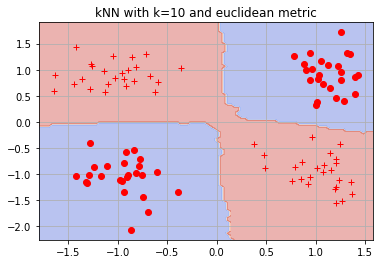

<Figure size 432x288 with 0 Axes>

In [88]:
k = 10
metric = 'euclidean'

vis_data(x_tra, y_tra, c='r')
plt1 = vis_decision_boundary('k--')

plt.show()
plt.tight_layout()

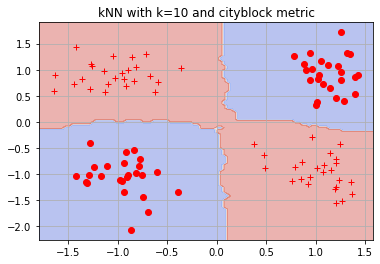

<Figure size 432x288 with 0 Axes>

In [73]:
k = 10
metric = 'cityblock'

vis_data(x_tra, y_tra, c='r')
plt1 = vis_decision_boundary('k--')

plt.show()
plt.tight_layout()

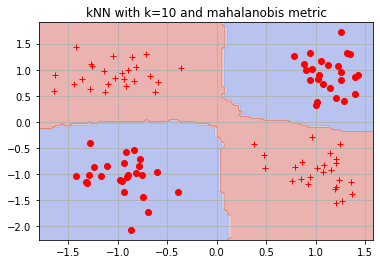

<Figure size 432x288 with 0 Axes>

In [74]:
k = 10
metric = 'mahalanobis'

vis_data(x_tra, y_tra, c='r')
plt1 = vis_decision_boundary('k--')

plt.show()
plt.tight_layout()

In [75]:
tra_er = numpy.sum(numpy.abs(knn_classify(x_tra, x_tra, y_tra, metric, k) - y_tra)) / numpy.float(len(y_tra))
tes_er = numpy.sum(numpy.abs(knn_classify(x_tes, x_tra, y_tra, metric, k) - y_tes)) / numpy.float(len(y_tes))

print(f'Training error rate {tra_er}, Test error rate {tes_er}')

Training error rate 0.0, Test error rate 0.29


# MNIST classification with kNN

In [76]:
class MNIST:
    def __init__(self, path):
        mnist = np.load(path)

        self.train_labels = mnist['train_labels']
        self.test_labels = mnist['test_labels']

        self.train_data = mnist['train_data']
        self.train_data = self.train_data.reshape(self.train_data.shape[0], -1)
        self.test_data = mnist['test_data']
        self.test_data = self.test_data.reshape(self.test_data.shape[0], -1)

In [ ]:
! wget 'https://nyu.box.com/shared/static/a7gsf7ouxm1qrqcoqa3rwdmc6awh0070.npz' -O './mnist.npz'

In [77]:
mnist = MNIST('./mnist.npz')

In [78]:
import time

def get_mnist_perf(num_train, k):
    start = time.time()
    tr_err = ((knn_classify(mnist.train_data[:100], mnist.train_data[:num_train], mnist.train_labels[:num_train], metric, k) - mnist.train_labels[:100]) != 0).sum() / numpy.float(len(mnist.train_labels[:100]))
    te_err = ((knn_classify(mnist.test_data[:100], mnist.train_data[:num_train], mnist.train_labels[:num_train], metric, k) - mnist.test_labels[:100]) != 0).sum() / numpy.float(len(mnist.test_labels[:100]))
    end = time.time()
    t = end - start
    print(f"# samples used = {num_train} with kNN k = {k}, done in {(t):.5f} seconds")
    
    print(f"Train error rate = {tr_err}")
    print(f"Test error rate = {te_err}")
    return te_err, t

In [79]:
metric = 'euclidean'
nts = [10, 100, 1000, 5000, 10000, 15000, 20000]
te_errs = []
times = []

for nt in nts:
    te_err, ti = get_mnist_perf(nt, 1)
    te_errs.append(te_err)
    times.append(ti)

# samples used = 10 with kNN k = 1, done in 0.00496 seconds
Train error rate = 0.55
Test error rate = 0.64
# samples used = 100 with kNN k = 1, done in 0.01212 seconds
Train error rate = 0.0
Test error rate = 0.33
# samples used = 1000 with kNN k = 1, done in 0.08449 seconds
Train error rate = 0.0
Test error rate = 0.17
# samples used = 5000 with kNN k = 1, done in 0.40250 seconds
Train error rate = 0.0
Test error rate = 0.1
# samples used = 10000 with kNN k = 1, done in 1.54725 seconds
Train error rate = 0.0
Test error rate = 0.08
# samples used = 15000 with kNN k = 1, done in 2.50033 seconds
Train error rate = 0.0
Test error rate = 0.03
# samples used = 20000 with kNN k = 1, done in 3.38030 seconds
Train error rate = 0.0
Test error rate = 0.05


Text(0, 0.5, 'Test error rate (100 samples)')

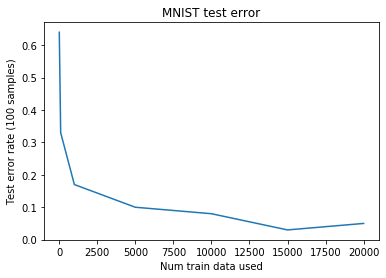

In [80]:
plt.plot(nts, te_errs)
plt.title('MNIST test error')
plt.xlabel('Num train data used')
plt.ylabel('Test error rate (100 samples)')

Text(0, 0.5, 'Running time in seconds (100 samples)')

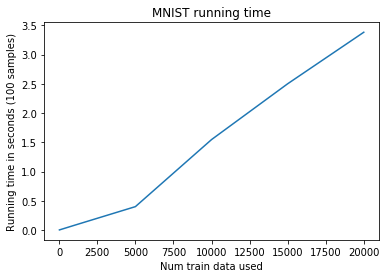

In [81]:
plt.plot(nts, times)
plt.title('MNIST running time')
plt.xlabel('Num train data used')
plt.ylabel('Running time in seconds (100 samples)')